In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import print_function, division
import os
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [0]:
data_dir = "/content/drive/My Drive/dataset/"
Train_dir = data_dir + '/Train'
Test_dir = data_dir + '/Test'
using_gpu = torch.cuda.is_available()

In [0]:
input_shape = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]


In [0]:
data_transforms = {
   'Train': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'Test': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}

In [0]:
image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['Train','Test']
}


In [0]:
dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=4
   )
   for x in ['Train','Test']
}

In [0]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train','Test']}


In [0]:
print(dataset_sizes)
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'Train': 170, 'Test': 160}


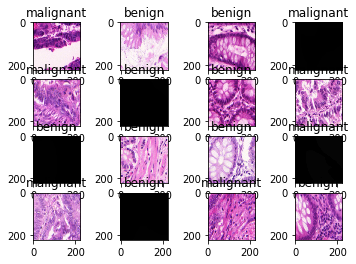

In [0]:
images, labels = next(iter(dataloaders['Train']))

rows = 4
columns = 4
fig=plt.figure()
for i in range(16):
    fig.add_subplot(rows, columns, i+1)
    plt.title(class_names[labels[i]])
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    plt.imshow(img)
plt.show()

In [0]:
## Load the model based on VGG19
vgg_based = torchvision.models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:13<00:00, 42826678.04it/s]


In [0]:
## freeze the layers
for param in vgg_based.parameters():
    param.requires_grad = False


In [0]:
# Modify the last layer
number_features = vgg_based.classifier[6].in_features
features = list(vgg_based.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(class_names))])
vgg_based.classifier = torch.nn.Sequential(*features)

vgg_based = vgg_based.to(device)

print(vgg_based)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

       #set model to trainable
       # model.train()

        train_loss = 0

       # Iterate over data.
        for i, data in enumerate(dataloaders['Train']):
            inputs , labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
          
            with torch.set_grad_enabled(True):
                outputs  = model(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

                print('{} Loss: {:.4f}'.format(
               'train', train_loss / dataset_sizes['Train']))
          
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} truth: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = std * img + mean
                ax.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
vgg_based = train_model(vgg_based, criterion, optimizer_ft, num_epochs=10)



Epoch 0/9
----------
train Loss: 0.0891
train Loss: 0.1926
train Loss: 0.2673
train Loss: 0.3474
train Loss: 0.4261
train Loss: 0.4642
Epoch 1/9
----------
train Loss: 0.0713
train Loss: 0.1739
train Loss: 0.2576
train Loss: 0.3427
train Loss: 0.4520
train Loss: 0.4775
Epoch 2/9
----------
train Loss: 0.0783
train Loss: 0.1536
train Loss: 0.2238
train Loss: 0.2970
train Loss: 0.3979
train Loss: 0.4243
Epoch 3/9
----------
train Loss: 0.0775
train Loss: 0.1526
train Loss: 0.2280
train Loss: 0.3256
train Loss: 0.4434
train Loss: 0.4665
Epoch 4/9
----------
train Loss: 0.0992
train Loss: 0.2011
train Loss: 0.2982
train Loss: 0.3833
train Loss: 0.4521
train Loss: 0.4680
Epoch 5/9
----------
train Loss: 0.0755
train Loss: 0.1452
train Loss: 0.2254
train Loss: 0.3075
train Loss: 0.4040
train Loss: 0.4259
Epoch 6/9
----------
train Loss: 0.0976
train Loss: 0.1735
train Loss: 0.2622
train Loss: 0.3580
train Loss: 0.4450
train Loss: 0.4620
Epoch 7/9
----------
train Loss: 0.0703
train Loss: 0.1

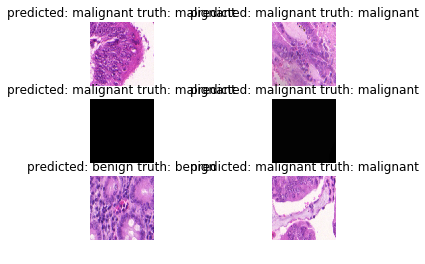

In [0]:
visualize_model(vgg_based)

plt.show()